In [11]:
import glob
import os.path as os
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms as T


In [9]:
# 입력 이미지 전처리 클래스
# train과 valid의 처리가 다름

class ImageTransform():
    """
    이미지 전처리 클래스, 훈련/검증 시 동작이 다름
    이미지 크기를 리사이즈하고 색상을 표준화함
    훈련 시에는 RandomResizedCrop와 RandomHorizontalFlip을 추가 적용
    
    Attributes
    ----------
    resize : int
        리사이즈 크기
    mean : (R, G, B)
        색상 채널별 평균
    std : (R, G, B)
        색상 채널별 표준편차
    """

    def __init__(self, resize, mean, std):
        self.data_transform ={
            'train': T.Compose([
                T.RandomResizedCrop(
                    resize, scale = (0.5, 1.0)),
                T.RandomHorizontalFlip(),
                T.ToTensor(), # 텐서화
                T.Normalize(mean, std) # 표준화
            ]),
            'val' : T.Compose([
                T.Resize(resize),
                T.CenterCrop(resize), 
                T.ToTensor(), # 텐서화
                T.Normalize(mean, std) # 표준화
                ])
            }
    
    def __call__(self, img, phase = 'train'):
        """
        Parameters
        __________
        phase : train or val
        """
        return self.data_transform[phase](img)
        
    

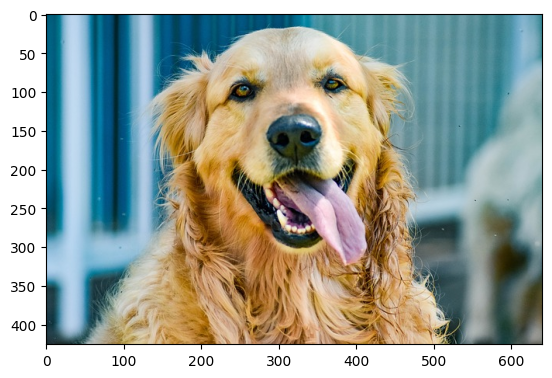

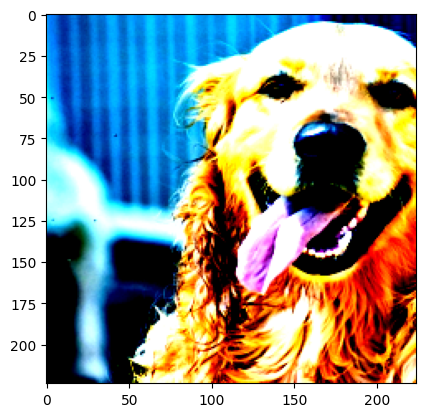

In [10]:
# ImageTransform 동작 확인
# 1. 이미지 불러오기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) #(h, w, c)

# 2. 이미지 출력
plt.imshow(img)
plt.show()

# 3. 이미지 전처리 및 출력
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(resize, mean, std)
img_trans = transform(img) # (c, h, w)

img_trans = img_trans.numpy().transpose((1,2,0))
img_trans = np.clip(img_trans, 0, 1)
plt.imshow(img_trans)
plt.show()

In [14]:
# 개미와 벌이 담긴 이미지 경로 리스트 작성
def make_datapath_list(phase='train'):
    """
    데이터의 경로를 저장한 리스트 생성

    Parameters
    ----------
    phase : 'train' or 'val'

    Returns
    ----------
    path_list : list
    """

    root_path = './data/hymenoptera_data/'
    target_path = os.join(root_path+phase+'/**/*.jpg')
    print(target_path)

    path_list = [] 

    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list
    
          
train_list = make_datapath_list()
val_list = make_datapath_list('val')

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


In [21]:
# custom dataset 작성
class CustomDataset(data.Dataset):
    """
    custom data set, 파이토치의 dataset 클래스 상속

    Attributes
    ----------
    file_list : 리스트
        
    transform : object
        
    phase : 'train' or 'val'
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로
        self.transform = transform  # 전처리 클래스 인스턴스
        self.phase = phase  # train or val

    def __len__(self):
        '''이미지 개수 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 이미지의 텐서 형식의 데이터와 label 을 가져오는 함수
        '''

        # index번쨰의 이미지 가져오기
        img_path = self.file_list[index]
        img = Image.open(img_path)  

        # 이미지 전처리
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 이미지 이름 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # label encoding
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 실행
train_dataset = CustomDataset(
    file_list=train_list, transform=ImageTransform(resize, mean, std), phase='train')

val_dataset = CustomDataset(
    file_list=val_list, transform=ImageTransform(resize, mean, std), phase='val')

# 테스트
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


In [22]:
# 데이터 로더 작성
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 테스트
batch_iterator = iter(dataloaders_dict["train"])  
inputs, labels = next(
    batch_iterator)  # 하나만 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0])


In [25]:
# 모델 작성
use_pretrained = True
model = models.vgg16(pretrained = use_pretrained)

# VGG16의 마지막 출력층의 output갯수를 2로 변경
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 학습 모드로 설정
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# 손실함수 설정 
criterion = nn.CrossEntropyLoss()

In [28]:
# 최적화 기법 설정 

# 전이학습에서 학습시킬 파라미터를 저장할 변수
params_to_update = []

# 학습시킬 파라미터 명 
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 외에는 업데이트 x 
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# 테스트
print("-----------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 1.3450e-02,  4.2154e-02, -2.3040e-03,  ..., -4.9025e-04,
          1.8880e-02, -1.4209e-02],
        [ 7.6020e-03,  4.7305e-02, -5.0164e-03,  ..., -4.9127e-03,
         -5.6295e-03, -1.4197e-02],
        [ 2.1238e-03, -1.2520e-02, -1.8903e-02,  ..., -1.0263e-02,
          3.0020e-02, -2.8852e-02],
        ...,
        [-9.8278e-03,  3.2054e-02,  3.5979e-02,  ..., -5.6409e-03,
          8.3202e-03, -7.5155e-03],
        [ 1.6646e-02, -1.1247e-03,  1.5044e-03,  ..., -9.1578e-03,
         -8.6418e-03, -2.0923e-02],
        [-6.4900e-06, -2.2274e-02,  5.2750e-04,  ...,  4.4403e-02,
         -9.4047e-03, -1.2332e-02]], requires_grad=True), Parameter containing:
tensor([ 2.0239e-02, -2.9844e-02, -6.0355e-03,  5.3569e-03,  2.4703e-02,
         9.4541e-04,  7.6767e-03, -1.2997e-02, -1.7257e-02,  2.4917e-03,
        -2.9578e-03, -1.2410e-02,  1.9179e-02,  2.2878e-02,  1.6132e-02,
        -1.5368e-02,  1.3967e-03,

In [29]:
# optimizer 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [30]:
# 모델 학습 및 검증 코드

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch 학습 및 검증 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 학습 모드로
            else:
                net.eval()   # 검증모드로 

            epoch_loss = 0.0  # epoch loss
            epoch_corrects = 0  # epoch 정확도

            # 학습전 val 성능 확인을 위해 
            if (epoch == 0) and (phase == 'train'):
                continue

            
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer 초기화
                optimizer.zero_grad()

                # 순전파（forward）계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  #손실값 계산
                    _, preds = torch.max(outputs, 1)  # label 예측
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    
                    # loss 합 갱신
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정확도 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch별 loss 및 정확도 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [31]:
# 学習・検証を実行する
num_epochs=2
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]


val Loss: 0.8291 Acc: 0.4314
Epoch 2/2
-------------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.70s/it]


train Loss: 0.8916 Acc: 0.4403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]

val Loss: 0.8291 Acc: 0.4314
